<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
df = pd.read_csv('libro.txt', sep='/n', header=None)
df.head(10)

<ipython-input-3-ca35b74d5f10>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('libro.txt', sep='/n', header=None)


,0
0,DEL LIBRO IMPRESO AL LIBRO DIGITAL
1,MARIE LEBERT
2,"NEF, Universidad de Toronto, 2010"
3,Copyright © 2010 Marie Lebert. Todos los derec...
4,---
5,Este libro está dedicado a todas las personas
6,que han contestado a mis preguntas
7,durante los últimos diez años
8,"en Europa, en las Américas,"
9,en África y en Asia.


In [4]:
article_text = ''
for i in range(len(df)):
    article_text += str(df.iloc[i][0]) + ' '

In [5]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

'DEL LIBRO IMPRESO AL LIBRO DIGITAL MARIE LEBERT NEF, Universidad de Toronto, 2010 Copyright © 2010 Marie Lebert. Todos los derechos reservados. --- Este libro está dedicado a todas las personas que han contestado a mis preguntas durante los últimos diez años en Europa, en las Américas, en África y en Asia. Gracias por el tiempo que me han dedicado, y por su amistad. --- El libro impreso tiene cinco siglos y medio de edad. El libro digital tiene ya 40 años. Hoy en día uno puede leer un libro en su ordenador, en su asistente personal (PDA), en su teléfono móvil, en su smartphone o en su tableta de lectura. Es el viaje "virtual" el que vamos a emprender en este libro, el que se ha basado en unas miles de horas de navegación en la web durante diez años y en una centena de entrevistas llevadas a cabo por el mundo entero. Este libro está también disponible en francés en el Proyecto Gutenberg y en ManyBooks.net. Marie Lebert, investigadora y periodista, se interesa por las tecnologías refere

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 50

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

116

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

### Organizando y estructurando el dataset

In [11]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [12]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [13]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [119]:
X.shape

(240717, 100)

In [120]:
X[0,:10]

array([ 39, 105,  79, 100,  79,  49,  21,  76,  88, 100])

In [121]:
y[0,:10]

array([105,  79, 100,  79,  49,  21,  76,  88, 100,  49])

In [17]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [18]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [22]:
model = Sequential()
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
#model.add(SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 116)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 100)           │          21,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 116)           │          11,716 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,516 (209.05 KB)

 Trainable params: 53,516 (209.05 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_lstm = Sequential()
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model_lstm.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(LSTM(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
#model.add(SimpleRNN(100, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_lstm.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_6 (TimeDistributed) │ (None, None, 116)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, None, 100)           │          86,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 116)           │          11,716 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,916 (698.89 KB)

 Trainable params: 178,916 (698.89 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [21]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.h5")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

#Modelo RNN

Epoch 1/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 2.6761


 mean perplexity: 7.55991387018232 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 333s 348ms/step - loss: 2.6757
Epoch 2/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 2.0183


 mean perplexity: 6.618622290654997 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 358s 322ms/step - loss: 2.0182
Epoch 3/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 1.9163


 mean perplexity: 6.244048496925548 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 337s 338ms/step - loss: 1.9163
Epoch 4/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.8710


 mean perplexity: 6.046588507307854 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 310s 330ms/step - loss: 1.8710
Epoch 5/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.8453


 mean perplexity: 5.9544408218946145 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 310s 318ms/step - loss: 1.8453
Epoch 6/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 1.8244


 mean perplexity: 5.839331124000551 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 340s 337ms/step - loss: 1.8244
Epoch 7/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.8143


 mean perplexity: 5.812393053830241 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 310s 330ms/step - loss: 1.8143
Epoch 8/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 1.8031


 mean perplexity: 5.6898316427374285 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 324s 332ms/step - loss: 1.8031
Epoch 9/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 1.7941


 mean perplexity: 5.66945995188693 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 299s 318ms/step - loss: 1.7941
Epoch 10/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 1.7852
 mean perplexity: 5.6769454480551556 

941/941 ━━━━━━━━━━━━━━━━━━━━ 332s 329ms/step - loss: 1.7852


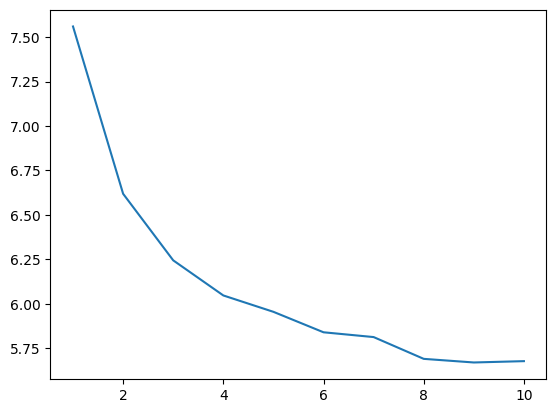

In [23]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

#Modelo LSTM

Epoch 1/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.2068


 mean perplexity: 14.16496417523485 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 305s 317ms/step - loss: 3.2066
Epoch 2/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.6196


 mean perplexity: 11.001724333313865 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 358s 359ms/step - loss: 2.6195
Epoch 3/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.4107


 mean perplexity: 9.796229657250304 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 332s 306ms/step - loss: 2.4106
Epoch 4/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.2983


 mean perplexity: 8.953099145223451 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 335s 356ms/step - loss: 2.2983
Epoch 5/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.2150


 mean perplexity: 8.350285584786494 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 383s 357ms/step - loss: 2.2150
Epoch 6/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 2.1540


 mean perplexity: 7.905515213153976 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 382s 357ms/step - loss: 2.1540
Epoch 7/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 2.1022


 mean perplexity: 7.553374513176153 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 383s 358ms/step - loss: 2.1022
Epoch 8/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 2.0608


 mean perplexity: 7.270113254828028 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 289s 308ms/step - loss: 2.0607
Epoch 9/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2.0241


 mean perplexity: 7.040317817708774 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 332s 319ms/step - loss: 2.0241
Epoch 10/10
941/941 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 1.9935


 mean perplexity: 6.837293769570103 

Saved new model!
941/941 ━━━━━━━━━━━━━━━━━━━━ 318s 315ms/step - loss: 1.9935


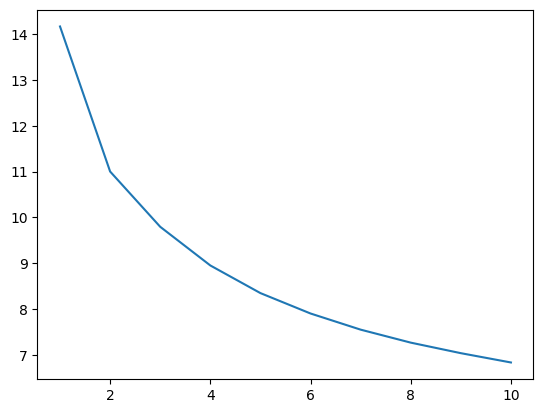

In [31]:
history_ppl = []
hist = model_lstm.fit(X, y, epochs=10, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=256)

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

#Tomo el modelo RNN

In [24]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.h5')


### Predicción del próximo caracter

In [25]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 5.8 MB/s eta 0:00:00


In [26]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c00fa95350395f8c35.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c00fa95350395f8c35.gradio.live


### Generación de secuencias

In [27]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [28]:
input_text='escribir un libro'

generate_seq(model, input_text, max_length=max_context_size, n_words=40)

'escribir un libros de la internet de la proyecto Gratura '

###  Beam search y muestreo aleatorio

In [29]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [30]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [43]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="escribir un libro")

In [44]:
salidas[0]

array([ 82,  40, 103,  37,  77,  68,  77,  37,  31,  22, 107,  31, 105,
        77,  68,  37,  34,  40,  31,  62,  77,  78,  77,  63,  59, 105,
        77,  24,  59, 103,  77, 110, 107,  31,  62,  82,  31])

In [45]:
# veamos las salidas
decode(salidas[0])

'escribir un libros digitalización de '